**Name:** David Björelind

**EID:** 40107147

**Kaggle Team Name:** \_\_\_\_\_

# CS4487 - Assignment 1 - YouTube Spam Classifier

## Goal
In this assignment, the task is predict whether a comment about a YouTube video is spam or not.  Here are some examples of spam and not spam:
  - **spam**: _"Huh, anyway check out this you[tube] channel: kobyoshi02"_
  - **not spam**: _"Still watching this 2 years later?"_

Your goal is to train a classifier to predict whether a comment is spam or not.


## Methodology
You need to train classifiers using the training data, and then predict on the test data. You are free to choose the feature extraction method and classifier algorithm.  You are free to use methods that were not introduced in class.  You should probably do cross-validation to select a good parameters.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  A portion (~50%) of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining portion will be used to calculate your final ranking. The entry with the highest final ranking will win a prize!  Also the top-ranked entries will be asked to give a short 5 minute presentation on what they did.

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas.

**Note:** You can only submit 2 times per day to Kaggle!

## What to hand in
You need to turn in the following things:

1. This ipynb file `Assignment1.ipynb`, containing your source code and documentation. _**You should write about all the various attempts that you make to find a good solution.**_
2. Your final submission file to Kaggle.
3. The ipynb file `Assignment1-Final.ipynb`, which contains the code that generates the final submission file that you submit to Kaggle.  **This code will be used to verify that your Kaggle submission is reproducible.**

Files should be uploaded to Assignment 1 on Canvas.

## Grading
The marks of the assignment are distributed as follows:
- 40% - Results using various classifiers and feature representations.
- 20% - Trying out feature representations (e.g. adding additional features) or classifiers not used in the tutorials.
- 20% - Quality of the written report.  More points for insightful observations and analysis.
- 20% - Final ranking on the Kaggle test data (private leaderboard). If a submission cannot be reproduced by the submitted code, it will not receive marks for ranking.
- **Late Penalty:** 25 marks will be subtracted for each day late.

**Note:** you should start early! Some classifiers may take a while to train.
<hr>

# Load the Data

The training data is in the text file `youtube_spam_train.csv`.  This CSV file contains the comment text, comment author names, date, video IDs, and classes. The class labels are: `0` for "not spam", and `1` for "spam". 

The testing data is in the text file `youtube_spam_test.csv`, and includes everything except the class labels. 

Note that the data is in chronological order -- the dates of the training data precede the dates of the test data.  This is to make the experiment more like a real situation, where we collect data up to a certain time to train the models, and then test on the new incoming data.

Besides the comment text, you can also use the author names, video names, or dates to build your classifier.

To submit to Kaggle, you need to generate a Kaggle submission files, which is CSV file with the following format: 

<pre>
Id,Prediction
1,0
2,1
3,1
4,0
...
</pre>

Here are some helpful code to get you started reading the data and writing the Kaggle submission file.

In [2]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
import pandas as pd

# a function for plotting the word probabilities
def plotWordProb(model):
    xr = arange(0,len(cntvect.vocabulary_))
    plt.figure(figsize=(8,3))
    plt.bar(xr, exp(model.feature_log_prob_[0,:]), width=0.4, label= "0")
    plt.bar(xr+0.5, exp(model.feature_log_prob_[1,:]), width=0.4, color='r', label= "1")
    plt.legend()
    plt.xlabel('word index'); plt.ylabel('probability $p(x_j=1|y)$');
    plt.xlim(min(xr), max(xr)+1)

/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/davidbjorelind/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This mod

In [3]:
# function to write a CSV file for Kaggle submission
def write_csv_kaggle_sub(fname, Y):
    # fname = file name
    # Y is a list/array with class entries
    with open(fname, 'w') as f:
        writer = csv.writer(f)

        # header
        tmp = ['Id', 'Prediction']            
        writer.writerow(tmp)
    
        # add ID numbers for each Y, and usage if necessary
        for (i,y) in enumerate(Y):
            tmp2 = [(i+1), y]
            writer.writerow(tmp2)
        
        f.close()

The below code will load the training and test sets.

In [4]:
# load the data with pandas
traindf = pd.read_csv('youtube_spam_train.csv')
testdf  = pd.read_csv('youtube_spam_test.csv')

# extract data into a dictionary

train = {}                                 ### training data
train['txt']   = list(traindf['TEXT'])     # comment text
train['class'] = list(traindf['CLASS'])    # class (0=not spam; 1=spam)
train['author'] = list(traindf['AUTHOR'])  # author name
train['video']  = list(traindf['VIDEO'])   # video ID
train['date']   = list(traindf['DATE'])    # date of the comment

test = {}                                  ### testing data
test['txt']   = list(testdf['TEXT'])
test['author'] = list(testdf['AUTHOR'])
test['video']  = list(testdf['VIDEO'])
test['date']    = list(testdf['DATE'])

print(len(train['txt']))
print(len(test['txt']))

1000
956


Here is an example to write a csv file with some predictions on the test set.

In [5]:
# write your predictions on the test set
predY = zeros(len(test['txt'])) # for example, predict all 0
write_csv_kaggle_sub("my_submission.csv", predY)

Look at the first 10 samples in the training data:

In [11]:
for t in range(100):
    print("=== Class={}, Video={}, Author={}, Date={}".format( 
        train['class'][t], train['video'][t], 
        train['author'][t], train['date'][t]))
    print(train['txt'][t])

=== Class=0, Video=pRpeEdMmmQ0, Author=Latin Bosch, Date=2013-07-12T22:33:27.916000
Shakira is the best dancer
=== Class=0, Video=pRpeEdMmmQ0, Author=Aishlin Maciel, Date=2013-07-13T11:17:52.308000
Shakira u are so wiredo
=== Class=0, Video=pRpeEdMmmQ0, Author=jeffrey jules, Date=2013-07-13T12:09:31.188000
wow
=== Class=0, Video=pRpeEdMmmQ0, Author=Sabina Pearson-Smith, Date=2013-07-13T13:14:30.021000
I love this song for two reasons: 1.it is about Africa 2.i was born in beautiful south Africa
=== Class=0, Video=pRpeEdMmmQ0, Author=Katie Mettam, Date=2013-07-13T13:27:39.441000
I love this song because we sing it at Camp all the time!!
=== Class=0, Video=pRpeEdMmmQ0, Author=Dinova Sharon, Date=2013-07-13T14:44:00.700000
well done shakira
=== Class=0, Video=pRpeEdMmmQ0, Author=TheHotChocolate, Date=2013-07-13T18:26:37.017000
she is sooooo beautiful!
=== Class=0, Video=pRpeEdMmmQ0, Author=Ysobel Schofield, Date=2013-07-13T20:17:25.181000
Waka waka she rules
=== Class=1, Video=pRpeEdMmmQ0,

# YOUR CODE and DOCUMENTATION HERE

In [12]:
### Looking at some more examples of spam comments

inds = []

for i in range(50):
    if train['class'][i] == 1:
        inds.append(i)

for t in inds:
    print("=== Class={}, Video={}, Author={}, Date={}".format( 
        train['class'][t], train['video'][t], 
        train['author'][t], train['date'][t]))
    print(train['txt'][t])

=== Class=1, Video=pRpeEdMmmQ0, Author=ThirdDegr3e, Date=2013-07-13T20:47:40.793000
**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE******CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE******CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE******CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE****
=== Class=1, Video=pRpeEdMmmQ0, Author=ThirdDegr3e, Date=2013-07-13T20:48:06.033000
**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE******CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** ***CHECK OUT MY NEW MIXTAPE******CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY NEW MIXTAPE*** *

In [59]:
### Due to the simularity with Tutorial 2, I will start by making a vocabulary from the training text data

stopwords = ['english', 'll', 'of', 'a']
cntvect = feature_extraction.text.CountVectorizer(stop_words = stopwords, max_features=300)

trainX = cntvect.fit_transform(train['txt'])
trainY = train['class']

# Train-vectors: date
trainXdate = cntvect.fit_transform(train['date'])

# calculate vectors for the test data
testX  = cntvect.transform(test['txt'])

### Making it pretty to print the vocab

def showVocab(vocab, counts=None):
    "print out the vocabulary. if counts specified, then only print the words w/ non-zero entries"
    allwords = list(vocab.keys())
    allwords.sort()  # sort vocabulary by index
    wordlist = []
    for word in allwords:
        ind = vocab[word]
        if (counts is None):
            mystr = "{:3d}. {}".format(ind, word)
        elif (counts[0,ind]>0):
            mystr = "{:3d}. ({:0.4f}) {}".format(ind, counts[0,ind], word)
        else:
            continue  # skip it
        wordlist.append(mystr)

    # print 2 columns
    it = iter(wordlist)
    for i in it:
        print('{:<30}{}'.format(i, next(it)))
            
# show the vocabulary
showVocab(cntvect.vocabulary_)


  0. 00                         1. 01
  2. 017000                     3. 01t03
  4. 01t04                      5. 01t17
  6. 01t19                      7. 01t21
  8. 02                         9. 02t00
 10. 02t02                     11. 02t03
 12. 02t12                     13. 02t13
 14. 02t14                     15. 02t15
 16. 02t18                     17. 02t19
 18. 02t22                     19. 02t23
 20. 03                        21. 030000
 22. 03t11                     23. 03t14
 24. 03t16                     25. 03t19
 26. 03t20                     27. 03t21
 28. 03t22                     29. 03t23
 30. 04                        31. 04t00
 32. 04t01                     33. 04t02
 34. 04t03                     35. 04t04
 36. 04t07                     37. 04t13
 38. 04t14                     39. 04t15
 40. 04t17                     41. 04t18
 42. 04t19                     43. 04t20
 44. 04t22                     45. 05
 46. 056000                    47. 05t00
 48. 05t01           

In [42]:
### Fit the NB Bernoulli model w/ smoothing do the data since it had the highest accuracy last time

firstModel = naive_bayes.BernoulliNB(alpha=0.01)
firstModel.fit(trainX, trainY)

BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)

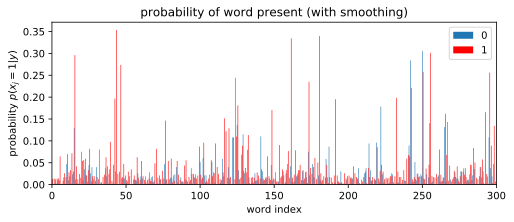

In [43]:
# Making a plot in order to evaluate the value of Alpha
plotWordProb(firstModel)
plt.title('probability of word present (with smoothing)');

In [44]:
## Getting the most informativive words

fnames = asarray(cntvect.get_feature_names())
# coef_ contains the scores for each word
# (higher means more informative)
# sort the coefficients in ascending order, and take the 10 largest.
tmp = argsort(firstModel.coef_[0])[-10:]

for i in tmp:
    print("{:3d}. {:15s} ({:.5f})".format(i, fnames[i], firstModel.coef_[0][i]))
    
## I'm not really sure what to do with this information

242. the             (-1.50840)
173. on              (-1.44732)
295. you             (-1.36216)
250. this            (-1.35538)
 46. com             (-1.29635)
 15. and             (-1.21681)
255. to              (-1.19931)
161. my              (-1.09512)
180. out             (-1.07961)
 43. check           (-1.03941)


In [45]:
## Making prediction on the train data because that all I can do to test the model

predYtrain = firstModel.predict(trainX)

# Calculating and printing accuracy
acc = metrics.accuracy_score(trainY, predYtrain)
print("Accuracy on the TRAIN data was: ", acc)

Accuracy on the TRAIN data was:  0.951


In [54]:
## I am proceeding by testing AdaBoost 

# setup the list of parameters to try
paramgrid = {'n_estimators': array([1, 2, 3, 25, 30, 35, 40, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 60, 65, 70, 100]) }
print(paramgrid)
# setup the cross-validation object
# (NOTE: using parallelization in GridSearchCV, not in AdaBoost)
adaBoost = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(random_state=4487),
paramgrid, cv=5, n_jobs=-1)
# run cross-validation (train for each split)
adaBoost.fit(trainX, trainY);
print("best params:", adaBoost.best_params_)

{'n_estimators': array([  1,   2,   3,  25,  30,  35,  40,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  60,  65,  70, 100])}
best params: {'n_estimators': 50}


In [55]:
# predict from the model
predYadaBoost = adaBoost.predict(trainX)
# calculate accuracy
acc = metrics.accuracy_score(trainY, predYadaBoost)
print("Accuracy on the TRAIN data was: ", acc)

Accuracy on the TRAIN data was:  0.975


In [61]:
## I am proceeding by testing Random Forest

# learn RF classifiers for different n_estimators
#plt.figure(figsize=(9,6))
clfsRF = {}
for i,n in enumerate([5, 10, 50, 100, 1000, 10000]):
    clfsRF[n] = ensemble.RandomForestClassifier(n_estimators=n, random_state=4487,
    n_jobs=-1)
    clfsRF[n].fit(trainX, trainY)
    predYRF = adaBoost.predict(trainX)
    accRF = metrics.accuracy_score(trainY, predYRF)
    print("Accuracy of RF with n= ", n, "is ", accRF)


Accuracy of RF with n=  5 is  0.975
Accuracy of RF with n=  10 is  0.975
Accuracy of RF with n=  50 is  0.975
Accuracy of RF with n=  100 is  0.975
Accuracy of RF with n=  1000 is  0.975
Accuracy of RF with n=  10000 is  0.975


In [83]:
paramgrid = {'n_estimators': array([10, 50, 100]), 'max_features': [10, 50, 100, 250] }

RFtest = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), paramgrid, cv=5, n_jobs=-1, verbose=True)
RFtest.fit(trainX, trainY)
print(RFtest.best_params_)

predYRFtest = adaBoost.predict(trainX)
accRFtest = metrics.accuracy_score(trainY, predYRFtest)
print("Accuracy of RF with CV is ", accRFtest)



Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.3s finished


{'max_features': 50, 'n_estimators': 50}
Accuracy of RF with CV is  0.975


In [90]:
count0s = 0
count1s = 0

for n in range(0, len(predYRFtest)):
    if (predYRFtest[n] == 0):
        count0s = count0s+1
    else:
        count1s = count1s+1

print(count0s, "  ", count1s)
print("ratio 0s: ", count0s/(count0s+count1s))
print("ratio 1s: ", count1s/(count0s+count1s))

433    567
ratio 0s:  0.433
ratio 1s:  0.567


In [65]:

clfRFdate = ensemble.RandomForestClassifier(n_estimators=50, random_state=4487, n_jobs=
-1)

clfRFdate.fit(trainXdate, trainY)
#print(trainXdate)

predYRFdate = adaBoost.predict(trainX)
accRFdate = metrics.accuracy_score(trainY, predYRFdate)
print("Accuracy of text and RF with n= ", n, "is ", accRFdate)

Accuracy of text and RF with n=  10000 is  0.975


In [81]:
## Comparing predYRFdate and predYadaBoost

diffinds = where (predYRFdate != predYadaBoost)

for n in range(0, len(predYRFdate)):
    if (predYRFdate[n] != predYadaBoost[n]):
        print(predYRFdate[n], " ",predYadaBoost[n])
    
        #print("same")
        

print(diffinds)
print("----")
print(predYRFdate)
print("---")
print(predYadaBoost)

(array([], dtype=int64),)
----
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0
 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1
 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1
 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 